In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# Getting Started MovieLens: ETL with NVTabular

## Overview

NVTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems.  It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.<br><br>

Deep Learning models require the input feature in a specific format. Categorical features needs to be continuous integers (0, ..., |C|) to use them with an embedding layer. We will use NVTabular to preprocess the categorical features.<br><br>

One other challenge is multi-hot categorical features. A product can have multiple categories assigned, but the number of categories per product varies. For example, a movie can have one or multiple genres:<br>
Father of the Bride Part II: \[Comedy\]<br>
Toy Story: \[Adventure, Animation, Children, Comedy, Fantasy\]<br>
Jumanji: \[Adventure, Children, Fantasy\]<br><br>
One strategy is often to use only the first category or the most frequent ones. However, a better strategy is to use all provided categories per datapoint. [RAPID cuDF](https://github.com/rapidsai/cudf) added list support in its [latest release v0.16](https://medium.com/rapids-ai/two-years-in-a-snap-rapids-0-16-ae797795a5c4) and  NVTabular now supports multi-hot categorical features. <br><br>

### Learning objectives

In this notebook, we learn how to `Categorify` single-hot and multi-hot categorical input features with NVTabular
- Learn NVTabular for using GPU-accelerated ETL (Preprocess and Feature Engineering)
- Get familiar with NVTabular's high-level API
- Join two dataframes with `JoinExternal` operator
- Preprocess single-hot categorical input features with NVTabular
- Preprocess multi-hot categorical input features with NVTabular
- Use `LambdaOp` for custom row-wise dataframe manipulations with NVTabular

### NVTabular

With the rapid growth in scale of industry datasets, deep learning (DL) recommender models have started to gain advantages over traditional methods by capitalizing on large amounts of training data.

The current challenges for training large-scale recommenders include:

* **Huge datasets:** Commercial recommenders are trained on huge datasets, often several terabytes in scale.
* **Complex data preprocessing and feature engineering pipelines:** Datasets need to be preprocessed and transformed into a form relevant to be used with DL models and frameworks. In addition, feature engineering creates an extensive set of new features from existing ones, requiring multiple iterations to arrive at an optimal solution.
* **Input bottleneck:** Data loading, if not well optimized, can be the slowest part of the training process, leading to under-utilization of high-throughput computing devices such as GPUs.
* **Extensive repeated experimentation:** The whole data engineering, training, and evaluation process is generally repeated many times, requiring significant time and computational resources.

**NVTabular** is a library for fast tabular data tranformation and loading, manipulating terabyte-scale datasets quickly. It provides best practices for feature engineering and preprocessing and a high-level abstraction to simplify code accelerating computation on the GPU using the RAPIDS cuDF library.

<img src='https://developer.nvidia.com/blog/wp-content/uploads/2020/07/recommender-system-training-pipeline-1.png'>

### Why using NVTabular?

NVTabular offers multiple advantages to support your Feature Engineering and Preprocessing:
1. **Larger than memory datasets**: Your dataset size can be larger than host/GPU memory. NVTabular reads the data from disk and stores the processed files to disk. It will execute your pipeline without exceeding the memory boundaries.
2. **Speed**: NVTabular will execute your pipeline on GPU. We experienced 10x-100x speed-up
3. **Easy-to-use**: NVTabular implemented common feature engineering and preprocessing operators and provides high-level APIs ready to use

## Getting Started

In [2]:
# External dependencies
import os
import cudf                 # cuDF is an implementation of Pandas-like Dataframe on GPU
import time
import gc

import nvtabular as nvt

from os import path

In [3]:
cudf.__version__

'0.18.0'

We define our base directory, containing the data.

In [4]:
BASE_DIR = os.path.expanduser("~/nvt-examples/movielens/data")

In [5]:
movies= cudf.read_parquet(os.path.join(BASE_DIR, "ml-25m", "movies_converted.parquet"))
movies.head()

,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]


### Defining our Preprocessing Pipeline
The first step is to define the feature engineering and preprocessing pipeline.<br><br>
NVTabular has already implemented multiple calculations, called `ops`. An `op` can be applied to a `ColumnGroup` from an overloaded `>>` operator, which in turn returns a new `ColumnGroup`. A `ColumnGroup` is a list of column names as text.<br><br>
**Example:**<br>
```python
features = [ column_name, ...] >> op1 >> op2 >> ...
```

This may sounds more complicated as it is. Let's define our first pipeline for the MovieLens dataset.

Currently, our dataset consists of two separate dataframes. First, we use the `JoinExternal` operator to `left-join` the metadata (genres) to our rating dataset.

In [6]:
joined = (
    ['userId', 'movieId'] >> 
    nvt.ops.JoinExternal(movies, on=['movieId'])
)

Data pipelines are **Directed Acyclic Graphs (DAGs)**. We can visualize them with `graphviz`.

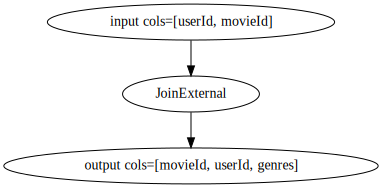

In [7]:
joined.graph

Embedding Layers of neural networks require that categorical features are contiguous, incremental Integers: 0, 1, 2, ... , |C|-1. We need to ensure that our categorical features fullfil the requirement.<br>

Currently, our genres are a list of Strings. In addition, we should transform the single-hot categorical features userId and movieId, as well.<br>
NVTabular provides the operator `Categorify`, which provides this functionality with a high-level API out of the box. In NVTabular release v0.3, list support was added for multi-hot categorical features. Both works in the same way with no need for changes.


Next, we will add `Categorify`  for our categorical features (single hot: userId, movieId and multi-hot: genres).

In [8]:
cat_features = joined >> nvt.ops.Categorify()

The ratings are on a scale between 1-5. We want to predict a binary target with 1 for ratings `>3` and 0 for  ratings `<=3`. We use the [LambdaOp](https://nvidia.github.io/NVTabular/main/api/ops/lambdaop.html) for it.

In [9]:
ratings = nvt.ColumnGroup(['rating']) >> (lambda col: (col>3).astype('int8'))

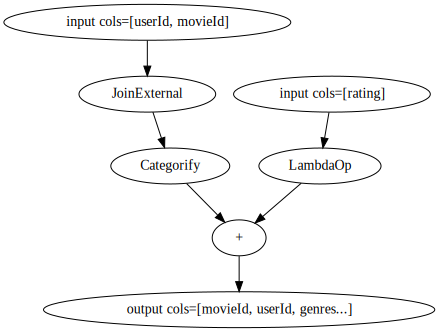

In [10]:
output = cat_features+ratings
(output).graph

We initialize our NVTabular `workflow`.

In [11]:
proc = nvt.Workflow(output)

### Running the pipeline

In general, the `Op`s in our `Workflow` will require measurements of statistical properties of our data in order to be leveraged. For example, the `Normalize` op requires measurements of the dataset mean and standard deviation, and the `Categorify` op requires an accounting of all the categories a particular feature can manifest. However, we frequently need to measure these properties across datasets which are too large to fit into GPU memory (or CPU memory for that matter) at once.

NVTabular solves this by providing the `Dataset` class, which breaks a set of parquet or csv files into into a collection of `cudf.DataFrame` chunks that can fit in device memory. The main purpose of this class is to abstract away the raw format of the data, and to allow other NVTabular classes to reliably materialize a dask_cudf.DataFrame collection (and/or collection-based iterator) on demand. Under the hood, the data decomposition corresponds to the construction of a [dask_cudf.DataFrame](https://docs.rapids.ai/api/cudf/stable/dask-cudf.html) object.  By representing our dataset as a lazily-evaluated [Dask](https://dask.org/) collection, we can handle the calculation of complex global statistics (and later, can also iterate over the partitions while feeding data into a neural network). `part_size` defines the size read into GPU-memory at once.

In [12]:
train_iter = nvt.Dataset([os.path.join(BASE_DIR, "train.parquet")], part_size="100MB")
valid_iter = nvt.Dataset([os.path.join(BASE_DIR, "valid.parquet")], part_size="100MB")

Now that we have our datasets, we'll apply our `Workflow` to them and save the results out to parquet files for fast reading at train time. Similar to the `scikit learn` API, we collect the statistics of our train dataset with `.fit`.

In [13]:
%%time

proc.fit(train_iter)

CPU times: user 1.36 s, sys: 723 ms, total: 2.08 s
Wall time: 2.1 s


We clear our output directories.

In [14]:
!rm -r $BASE_DIR/train
!rm -r $BASE_DIR/valid

We transform our workflow with `.transform`.

In [15]:
%time

proc.transform(train_iter).to_parquet(output_path=os.path.join(BASE_DIR, "train"), out_files_per_proc=7)
proc.transform(valid_iter).to_parquet(output_path=os.path.join(BASE_DIR, "valid"), out_files_per_proc=7)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 8.34 µs


We can take a look in the output dir.

In [16]:
!ls $BASE_DIR/train

0.1f1aa4a9e584465eb5aea9980da76703.parquet
1.d04ea16f5bb2457c997edda3cca98bc1.parquet
2.6f8c83d50b094b279c159e7421302b8c.parquet
3.673bb6a8fc78435cae2e60d1d5632a74.parquet
4.f5a31868f7224cd6b39e300ff3fe716c.parquet
5.56d547bb3fe94bad9c1e0479e01da6b9.parquet
6.c0074e33120048849cb673a65bcc526b.parquet
_file_list.txt
_metadata
_metadata.json


In the next notebooks, we will train a deep learning model. Our training pipeline requires information about the data schema to define the neural network architecture. We will save the NVTabular workflow to disk tha we can restore it in the next notebooks.

In [17]:
proc.save(os.path.join(BASE_DIR, "workflow"))

### Checking the pre-processing outputs

We can take a look on the data.

In [18]:
import glob

TRAIN_PATHS = sorted(glob.glob(os.path.join(BASE_DIR, "train", "*.parquet")))
VALID_PATHS = sorted(glob.glob(os.path.join(BASE_DIR, "valid", "*.parquet")))
TRAIN_PATHS, VALID_PATHS

(['/root/nvt-examples/movielens/data/train/0.1f1aa4a9e584465eb5aea9980da76703.parquet',
  '/root/nvt-examples/movielens/data/train/1.d04ea16f5bb2457c997edda3cca98bc1.parquet',
  '/root/nvt-examples/movielens/data/train/2.6f8c83d50b094b279c159e7421302b8c.parquet',
  '/root/nvt-examples/movielens/data/train/3.673bb6a8fc78435cae2e60d1d5632a74.parquet',
  '/root/nvt-examples/movielens/data/train/4.f5a31868f7224cd6b39e300ff3fe716c.parquet',
  '/root/nvt-examples/movielens/data/train/5.56d547bb3fe94bad9c1e0479e01da6b9.parquet',
  '/root/nvt-examples/movielens/data/train/6.c0074e33120048849cb673a65bcc526b.parquet'],
 ['/root/nvt-examples/movielens/data/valid/0.f9b6b4240cb34065a488a3df4799c4d1.parquet',
  '/root/nvt-examples/movielens/data/valid/1.8c55e1f7ca8045a3819c903c845b7bd5.parquet',
  '/root/nvt-examples/movielens/data/valid/2.2c6f695027664c5e848691aa772b3bf7.parquet',
  '/root/nvt-examples/movielens/data/valid/3.1c59d533213d466f9c4a342cad063628.parquet',
  '/root/nvt-examples/movielens

We can see, that genres are a list of Integers

In [19]:
df = cudf.read_parquet(TRAIN_PATHS[0])
df.head()

,movieId,userId,genres,rating
0,39844,5418,"[9, 12, 18]",1
1,28840,101070,[6],1
2,3643,144035,"[2, 7, 18]",0
3,1180,49955,"[2, 3, 17]",0
4,6543,122982,"[6, 9, 10]",0
